In [1]:
import pandas as pd
import numpy as np
import shutil
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD

In [2]:
%cd /content

!unzip -qq "/content/drive/MyDrive/KDEF_Angle2_V2.zip"

/content


In [3]:
!unzip -qq "/content/drive/MyDrive/KDEF_All_V2.zip"

# Load Data

In [4]:
# 불필요한 폴더 삭제
if os.path.exists("/content/KDEF_Angle2_V2/Train/.ipynb_checkpoints"):
    shutil.rmtree("/content/KDEF_Angle2_V2/Train/.ipynb_checkpoints")

if os.path.exists("/content/KDEF_All_V2/Test/.ipynb_checkpoints"):
    shutil.rmtree("/content/KDEF_All_V2/Test/.ipynb_checkpoints")

In [5]:
TEST_DIR = '/content/KDEF_All_V2/Test/'

In [6]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        if label == '.DS_Store':
            continue
        for filename in os.listdir(directory+label):
            if filename == '.DS_Store':
                continue
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [7]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


,image,label
0,/content/KDEF_All_V2/Test/surprised/BF03SUFR_A...,surprised
1,/content/KDEF_All_V2/Test/surprised/AM04SUS.JPG,surprised
2,/content/KDEF_All_V2/Test/surprised/BM05SUHR.JPG,surprised
3,/content/KDEF_All_V2/Test/surprised/AF01SUFR.JPG,surprised
4,/content/KDEF_All_V2/Test/surprised/BF08SUFL.JPG,surprised


# Define Feature Extraction Method

In [8]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
        img = np.array(cropped_img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 300, 224, 1)
    print(features.shape)
    return features

# 🧑 Straight Model 


> Straight 사진만 학습할 모델

---





In [9]:
TRAIN_DIR = '/content/KDEF_Angle2_V2/Train/straight/'

In [10]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


,image,label
0,/content/KDEF_Angle2_V2/Train/straight/afraid/...,afraid
1,/content/KDEF_Angle2_V2/Train/straight/sad/BM2...,sad
2,/content/KDEF_Angle2_V2/Train/straight/surpris...,surprised
3,/content/KDEF_Angle2_V2/Train/straight/sad/BM3...,sad
4,/content/KDEF_Angle2_V2/Train/straight/angry/B...,angry


## Exploratory Data Analysis

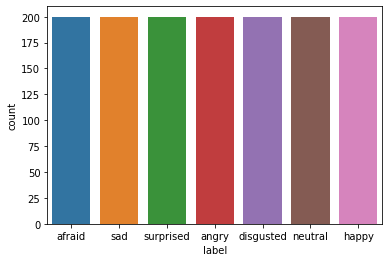

In [11]:
sns.countplot(train['label'])

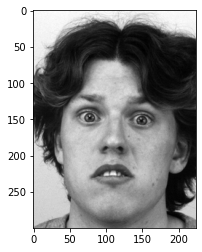

In [12]:
from PIL import Image

# center crop 적용 후, 224 x 300의 크기를 사용
img = Image.open(train['image'][0]).convert("L")
frac = 0.75
left = img.size[0]*((1-frac)/2)
upper = img.size[1]*((1-frac)/2)
right = img.size[0]-((1-frac)/2)*img.size[0]
bottom = img.size[1]-((1-frac)/2)*img.size[1]

cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
plt.imshow(cropped_img, cmap='gray');

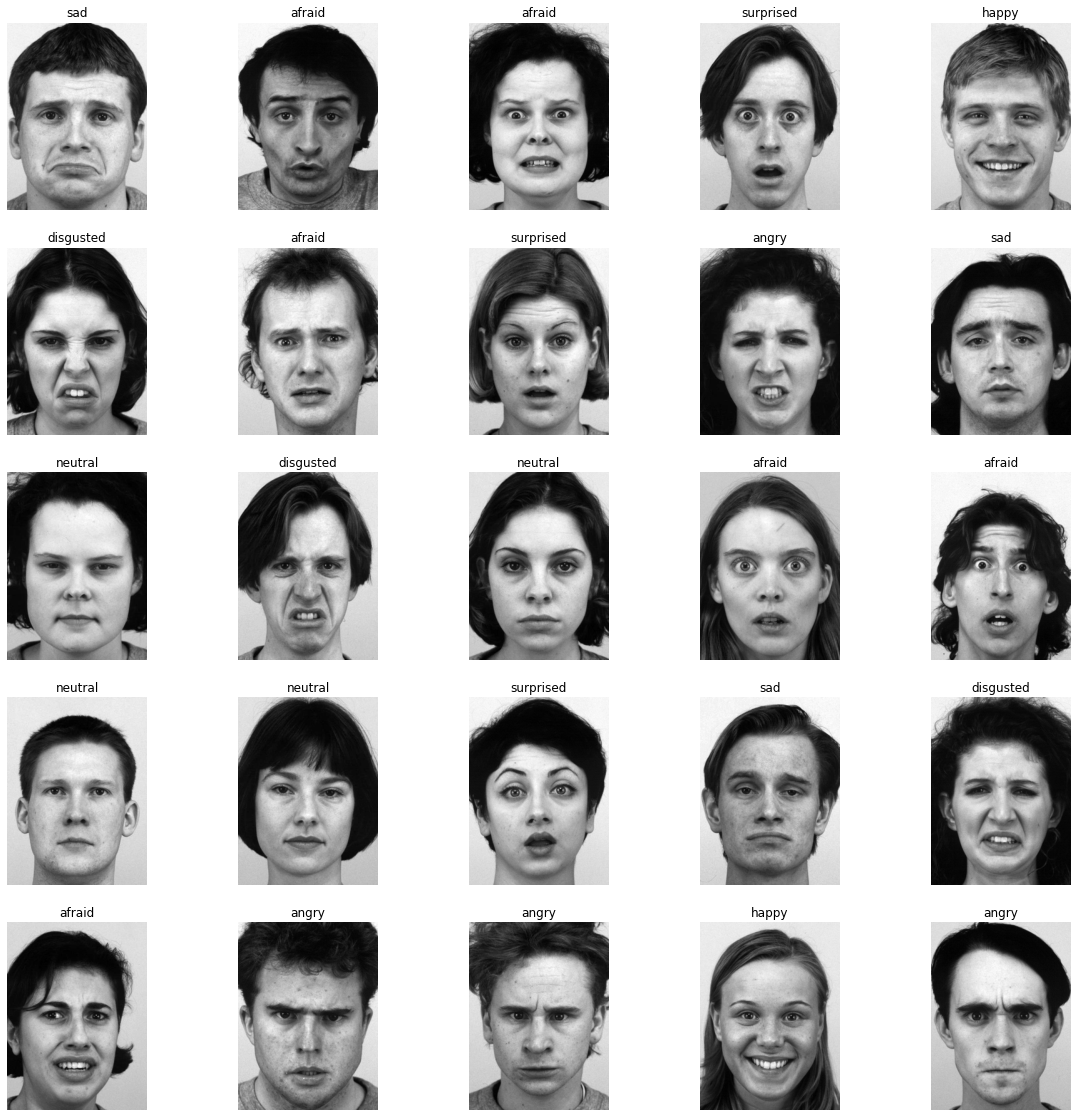

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file, grayscale=True)
    cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
    img = np.array(cropped_img)
    plt.imshow(cropped_img, cmap='gray')
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [ ]:
train_features = extract_features(train['image'])

  0%|          | 0/1400 [00:00<?, ?it/s]

(1400, 300, 224, 1)


In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/2800 [00:00<?, ?it/s]

(2800, 300, 224, 1)


In [ ]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [ ]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
# one-hot encoding
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [ ]:
print(y_train[0])
print(y_test[0])

[0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 1.]


## Model Creation

In [ ]:
# config
input_shape = (300, 224, 1)
output_class = 7

In [ ]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(output_class, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 298, 222, 128)     1280      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 149, 111, 128)    0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 149, 111, 128)     0         
                                                                 
 conv2d_17 (Conv2D)          (None, 147, 109, 256)     295168    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 73, 54, 256)      0         
 g2D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 73, 54, 256)      

In [ ]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
22/22 [==============================] - 6s 247ms/step - loss: 1.9514 - accuracy: 0.1407 - val_loss: 1.9455 - val_accuracy: 0.1482
Epoch 2/100
22/22 [==============================] - 4s 196ms/step - loss: 1.9424 - accuracy: 0.1686 - val_loss: 1.9451 - val_accuracy: 0.1582
Epoch 3/100
22/22 [==============================] - 4s 197ms/step - loss: 1.9392 - accuracy: 0.1736 - val_loss: 1.9448 - val_accuracy: 0.1779
Epoch 4/100
22/22 [==============================] - 4s 196ms/step - loss: 1.9301 - accuracy: 0.1743 - val_loss: 1.9445 - val_accuracy: 0.1925
Epoch 5/100
22/22 [==============================] - 4s 196ms/step - loss: 1.9316 - accuracy: 0.1750 - val_loss: 1.9442 - val_accuracy: 0.1857
Epoch 6/100
22/22 [==============================] - 4s 195ms/step - loss: 1.9235 - accuracy: 0.1714 - val_loss: 1.9437 - val_accuracy: 0.1979
Epoch 7/100
22/22 [==============================] - 4s 195ms/step - loss: 1.9200 - accuracy: 0.1850 - val_loss: 1.9430 - val_accuracy: 0.2086

## Plot the Results

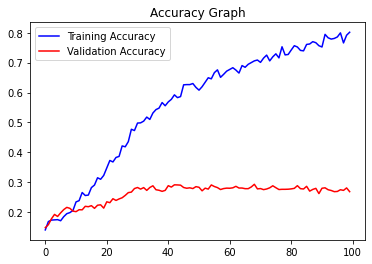

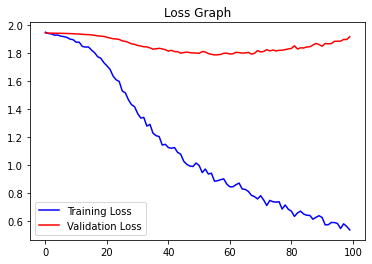

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Save Model

In [ ]:
model.save('fer_straight_v2.h5')

In [ ]:
!cp fer_straight_v2.h5 /content/drive/MyDrive

# 👈 👉 Side-View Model 


> 측면 사진만 학습할 모델

---





In [9]:
TRAIN_DIR = '/content/KDEF_Angle2_V2/Train/side/'

In [10]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


,image,label
0,/content/KDEF_Angle2_V2/Train/side/surprised/B...,surprised
1,/content/KDEF_Angle2_V2/Train/side/surprised/B...,surprised
2,/content/KDEF_Angle2_V2/Train/side/afraid/AF21...,afraid
3,/content/KDEF_Angle2_V2/Train/side/neutral/AF1...,neutral
4,/content/KDEF_Angle2_V2/Train/side/neutral/BF2...,neutral


## Exploratory Data Analysis

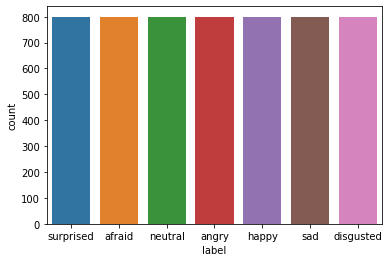

In [11]:
sns.countplot(train['label'])

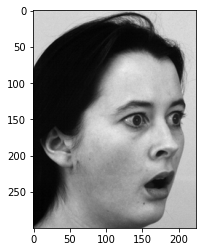

In [12]:
from PIL import Image

# center crop 적용 후, 224 x 300의 크기를 사용
img = Image.open(train['image'][0]).convert("L")
frac = 0.75
left = img.size[0]*((1-frac)/2)
upper = img.size[1]*((1-frac)/2)
right = img.size[0]-((1-frac)/2)*img.size[0]
bottom = img.size[1]-((1-frac)/2)*img.size[1]

cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
plt.imshow(cropped_img, cmap='gray');

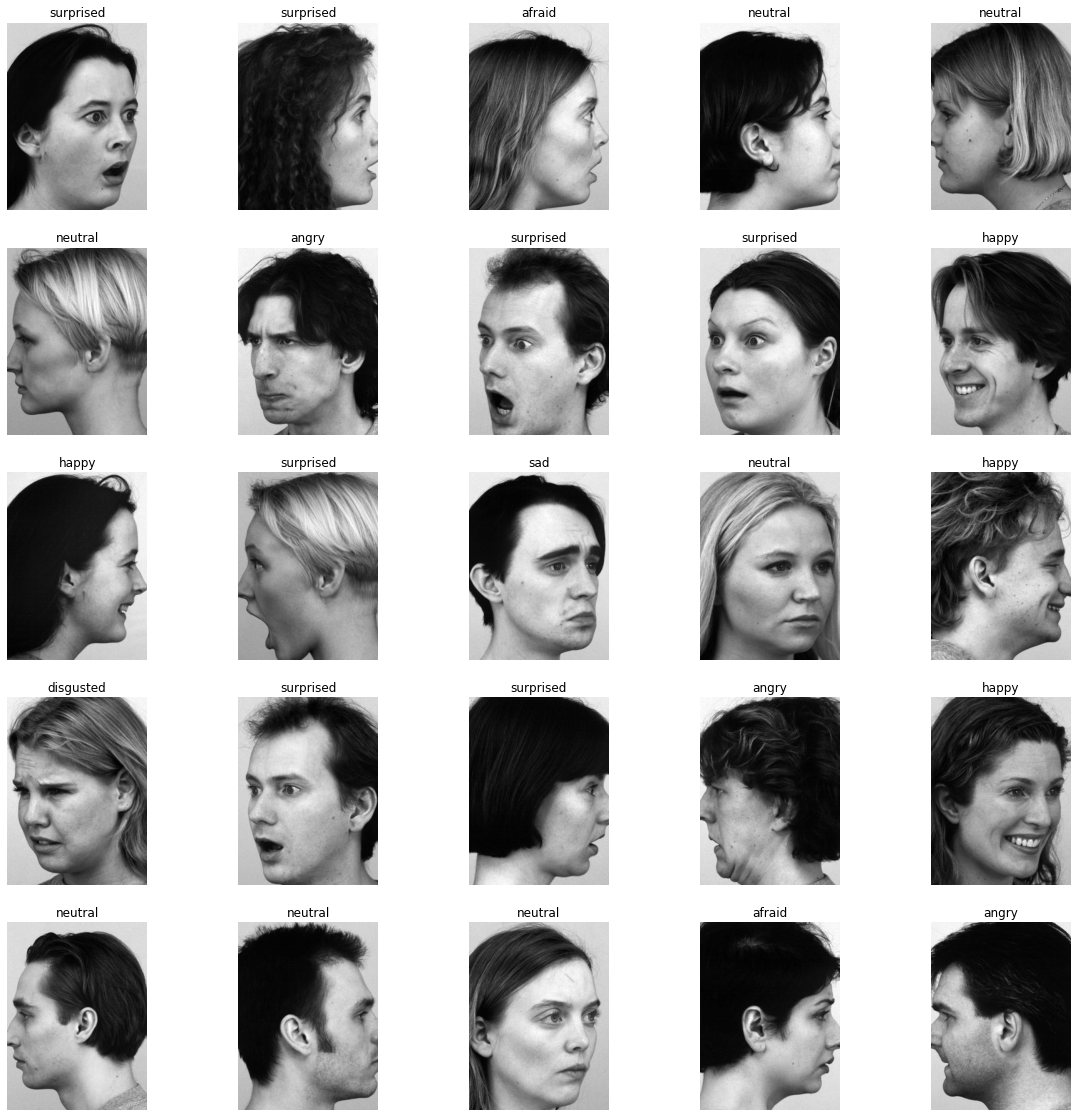

In [13]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file, grayscale=True)
    cropped_img = img.crop((left, upper, right, bottom)).resize((224,300), Image.ANTIALIAS)
    img = np.array(cropped_img)
    plt.imshow(cropped_img, cmap='gray')
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [14]:
train_features = extract_features(train['image'])

  0%|          | 0/5600 [00:00<?, ?it/s]

(5600, 300, 224, 1)


In [15]:
test_features = extract_features(test['image'])

  0%|          | 0/2800 [00:00<?, ?it/s]

(2800, 300, 224, 1)


In [16]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [17]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [18]:
# one-hot encoding
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [19]:
print(y_train[0])
print(y_test[0])

[0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 1.]


## Model Creation

In [20]:
# config
input_shape = (300, 224, 1)
output_class = 7

In [21]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(output_class, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 222, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 111, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 149, 111, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 109, 256)     295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 54, 256)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 73, 54, 256)       0

In [22]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
88/88 [==============================] - 26s 166ms/step - loss: 1.9486 - accuracy: 0.1568 - val_loss: 1.9445 - val_accuracy: 0.1618
Epoch 2/100
88/88 [==============================] - 12s 134ms/step - loss: 1.9399 - accuracy: 0.1711 - val_loss: 1.9432 - val_accuracy: 0.1879
Epoch 3/100
88/88 [==============================] - 12s 134ms/step - loss: 1.9261 - accuracy: 0.1800 - val_loss: 1.9410 - val_accuracy: 0.2139
Epoch 4/100
88/88 [==============================] - 12s 134ms/step - loss: 1.9230 - accuracy: 0.1834 - val_loss: 1.9397 - val_accuracy: 0.2150
Epoch 5/100
88/88 [==============================] - 12s 134ms/step - loss: 1.9149 - accuracy: 0.2000 - val_loss: 1.9384 - val_accuracy: 0.2029
Epoch 6/100
88/88 [==============================] - 12s 134ms/step - loss: 1.9123 - accuracy: 0.1977 - val_loss: 1.9369 - val_accuracy: 0.2089
Epoch 7/100
88/88 [==============================] - 12s 134ms/step - loss: 1.9051 - accuracy: 0.2013 - val_loss: 1.9364 - val_accuracy:

## Plot the Results

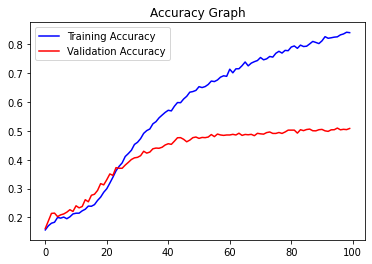

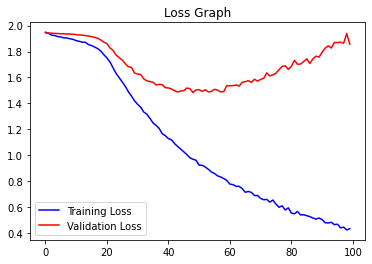

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Save Model

In [24]:
model.save('fer_side_v2.h5')

In [25]:
!cp fer_side_v2.h5 /content/drive/MyDrive

# 🏭 Ensemble Model


> 2개의 모델을 앙상블



## Feature Extraction

In [26]:
test_features = extract_features(test['image'])

  0%|          | 0/2800 [00:00<?, ?it/s]

(2800, 300, 224, 1)


In [27]:
## normalize the image
x_test = test_features/255.0

In [28]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [29]:
print(y_test)

[6 6 6 ... 0 0 0]


## Evaluate Ensemble

In [13]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [14]:
model_straight = tf.keras.models.load_model('/content/drive/MyDrive/fer_straight_v2.h5')
model_side = tf.keras.models.load_model('/content/drive/MyDrive/fer_side_v2.h5')

In [15]:
models = [model_straight, model_side]

In [16]:
def ensemble_predictions(models, test_x):
    # make predictions
    yhats = [model.predict(test_x, verbose = 0) for model in models]
    yhats = np.array(yhats)
    # sum across ensemble members
    summed = np.sum(yhats, axis=0)
    # argmax across classes
    result = np.argmax(summed, axis=1)
    return result

In [17]:
def evaluate_ensemble_model(models, test_x, test_y):
    # make prediction
    yhat = [ensemble_predictions(models, testData.reshape(1, 300, 224, 1)) for testData in tqdm(test_x)]
    # calculate accuracy
    return accuracy_score(test_y, yhat)

In [35]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 2800/2800 [03:55<00:00, 11.88it/s]


In [36]:
print(f'Accuracy : {score}')

Accuracy : 0.5114285714285715


# Evaluate Model Only with Angle

In [13]:
%cd /content

!unzip -qq "/content/drive/MyDrive/KDEF_TEST_FullLeft_V2.zip"

/content


In [14]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_HalfLeft_V2.zip"

In [15]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Straight_V2.zip"

In [16]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_HalfRight_V2.zip"

In [17]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_FullRight_V2.zip"

## Full Left

In [30]:
TEST_DIR_FullLeft = '/content/KDEF_TEST_FullLeft_V2/'

In [31]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_FullLeft)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


,image,label
0,/content/KDEF_TEST_FullLeft_V2/surprised/BF08S...,surprised
1,/content/KDEF_TEST_FullLeft_V2/surprised/BM07S...,surprised
2,/content/KDEF_TEST_FullLeft_V2/surprised/AM06S...,surprised
3,/content/KDEF_TEST_FullLeft_V2/surprised/BM08S...,surprised
4,/content/KDEF_TEST_FullLeft_V2/surprised/BF04S...,surprised


In [35]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 560/560 [00:06<00:00, 83.34it/s] 


(560, 300, 224, 1)


In [38]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])

In [39]:
score = evaluate_ensemble_model(models, x_test, y_test)


100%|██████████| 560/560 [01:15<00:00,  7.45it/s]


In [40]:
print(f'Accuracy : {score}')

Accuracy : 0.4928571428571429


## Half Left

In [41]:
TEST_DIR_HalfLeft = '/content/KDEF_TEST_HalfLeft_V2/'

In [42]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_HalfLeft)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


,image,label
0,/content/KDEF_TEST_HalfLeft_V2/surprised/BF05S...,surprised
1,/content/KDEF_TEST_HalfLeft_V2/surprised/BF03S...,surprised
2,/content/KDEF_TEST_HalfLeft_V2/surprised/AF03S...,surprised
3,/content/KDEF_TEST_HalfLeft_V2/surprised/AM02S...,surprised
4,/content/KDEF_TEST_HalfLeft_V2/surprised/BF08S...,surprised


In [43]:
test_features = extract_features(test['image'])
x_test = test_features/255.0


100%|██████████| 560/560 [00:07<00:00, 72.39it/s]


(560, 300, 224, 1)


In [44]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])

In [45]:
score = evaluate_ensemble_model(models, x_test, y_test)


100%|██████████| 560/560 [01:11<00:00,  7.88it/s]


In [46]:
print(f'Accuracy : {score}')

Accuracy : 0.6035714285714285


## Straight

In [47]:
TEST_DIR_Straight = '/content/KDEF_TEST_Straight_V2/'

In [48]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Straight)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


,image,label
0,/content/KDEF_TEST_Straight_V2/surprised/AM04S...,surprised
1,/content/KDEF_TEST_Straight_V2/surprised/BM08S...,surprised
2,/content/KDEF_TEST_Straight_V2/surprised/AM02S...,surprised
3,/content/KDEF_TEST_Straight_V2/surprised/BM07S...,surprised
4,/content/KDEF_TEST_Straight_V2/surprised/AF08S...,surprised


In [49]:
test_features = extract_features(test['image'])
x_test = test_features/255.0


100%|██████████| 560/560 [00:05<00:00, 99.42it/s]


(560, 300, 224, 1)


In [50]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])

In [51]:
score = evaluate_ensemble_model(models, x_test, y_test)


100%|██████████| 560/560 [01:13<00:00,  7.61it/s]


In [52]:
print(f'Accuracy : {score}')

Accuracy : 0.3732142857142857


## Half Right

In [53]:
TEST_DIR_HalfRight = '/content/KDEF_TEST_HalfRight_V2/'

In [54]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_HalfRight)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


,image,label
0,/content/KDEF_TEST_HalfRight_V2/surprised/BM05...,surprised
1,/content/KDEF_TEST_HalfRight_V2/surprised/BF05...,surprised
2,/content/KDEF_TEST_HalfRight_V2/surprised/BM09...,surprised
3,/content/KDEF_TEST_HalfRight_V2/surprised/BF03...,surprised
4,/content/KDEF_TEST_HalfRight_V2/surprised/BM06...,surprised


In [55]:
test_features = extract_features(test['image'])
x_test = test_features/255.0


100%|██████████| 560/560 [00:05<00:00, 100.43it/s]


(560, 300, 224, 1)


In [56]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])

In [57]:
score = evaluate_ensemble_model(models, x_test, y_test)


100%|██████████| 560/560 [01:09<00:00,  8.08it/s]


In [58]:
print(f'Accuracy : {score}')

Accuracy : 0.6053571428571428


## Full Right

In [59]:
TEST_DIR_FullRight = '/content/KDEF_TEST_FullRight_V2/'

In [60]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_FullRight)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


,image,label
0,/content/KDEF_TEST_FullRight_V2/surprised/BF03...,surprised
1,/content/KDEF_TEST_FullRight_V2/surprised/AF01...,surprised
2,/content/KDEF_TEST_FullRight_V2/surprised/AM05...,surprised
3,/content/KDEF_TEST_FullRight_V2/surprised/AM02...,surprised
4,/content/KDEF_TEST_FullRight_V2/surprised/AM10...,surprised


In [61]:
test_features = extract_features(test['image'])
x_test = test_features/255.0


100%|██████████| 560/560 [00:05<00:00, 101.01it/s]


(560, 300, 224, 1)


In [62]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(test['label'])
y_test = le.transform(test['label'])

In [63]:
score = evaluate_ensemble_model(models, x_test, y_test)


100%|██████████| 560/560 [01:09<00:00,  8.11it/s]


In [64]:
print(f'Accuracy : {score}')

Accuracy : 0.48214285714285715


# Evaluate Model Only with Emotion

In [18]:
%cd /content

!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Afraid_V2.zip"

/content


In [19]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Angry_V2.zip"

In [20]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Disgusted_V2.zip"

In [21]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Happy_V2.zip"

In [22]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Neutral_V2.zip"

In [23]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Sad_V2.zip"

In [24]:
!unzip -qq "/content/drive/MyDrive/KDEF_TEST_Surprised_V2.zip"

## Afraid

In [25]:
TEST_DIR_Afraid = '/content/KDEF_TEST_Afraid_V2/'

In [26]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Afraid)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


,image,label
0,/content/KDEF_TEST_Afraid_V2/afraid/BF06AFS_AU...,afraid
1,/content/KDEF_TEST_Afraid_V2/afraid/AM07AFHR.JPG,afraid
2,/content/KDEF_TEST_Afraid_V2/afraid/BF08AFHR_A...,afraid
3,/content/KDEF_TEST_Afraid_V2/afraid/AM07AFHL.JPG,afraid
4,/content/KDEF_TEST_Afraid_V2/afraid/AM04AFHL_A...,afraid


In [27]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 400/400 [00:03<00:00, 109.30it/s]


(400, 300, 224, 1)


In [28]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [29]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 400/400 [01:03<00:00,  6.30it/s]


In [30]:
print(f'Accuracy : {score}')

Accuracy : 0.215


## Angry

In [31]:
TEST_DIR_Angry = '/content/KDEF_TEST_Angry_V2/'

In [32]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Angry)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


,image,label
0,/content/KDEF_TEST_Angry_V2/angry/BF08ANHL.JPG,angry
1,/content/KDEF_TEST_Angry_V2/angry/BF06ANFL_AUG...,angry
2,/content/KDEF_TEST_Angry_V2/angry/AF02ANFR.JPG,angry
3,/content/KDEF_TEST_Angry_V2/angry/AM04ANFL.JPG,angry
4,/content/KDEF_TEST_Angry_V2/angry/AF10ANFR_AUG...,angry


In [33]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 400/400 [00:03<00:00, 108.81it/s]


(400, 300, 224, 1)


In [34]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [35]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 400/400 [00:43<00:00,  9.28it/s]


In [36]:
print(f'Accuracy : {score}')

Accuracy : 0.5775


## Disgusted

In [37]:
TEST_DIR_Disgusted = '/content/KDEF_TEST_Disgusted_V2/'

In [38]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Disgusted)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


,image,label
0,/content/KDEF_TEST_Disgusted_V2/disgusted/AF07...,disgusted
1,/content/KDEF_TEST_Disgusted_V2/disgusted/BF08...,disgusted
2,/content/KDEF_TEST_Disgusted_V2/disgusted/AF09...,disgusted
3,/content/KDEF_TEST_Disgusted_V2/disgusted/BM08...,disgusted
4,/content/KDEF_TEST_Disgusted_V2/disgusted/BF04...,disgusted


In [39]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 400/400 [00:03<00:00, 109.79it/s]


(400, 300, 224, 1)


In [40]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [41]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 400/400 [00:43<00:00,  9.24it/s]


In [42]:
print(f'Accuracy : {score}')

Accuracy : 0.6075


## Happy

In [43]:
TEST_DIR_Happy= '/content/KDEF_TEST_Happy_V2/'

In [44]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Happy)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


,image,label
0,/content/KDEF_TEST_Happy_V2/happy/AM07HAS.JPG,happy
1,/content/KDEF_TEST_Happy_V2/happy/BM03HAFL_AUG...,happy
2,/content/KDEF_TEST_Happy_V2/happy/BM06HAHR.JPG,happy
3,/content/KDEF_TEST_Happy_V2/happy/AM10HAHR.JPG,happy
4,/content/KDEF_TEST_Happy_V2/happy/AM01HAS_AUG.jpg,happy


In [45]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 400/400 [00:03<00:00, 107.56it/s]


(400, 300, 224, 1)


In [46]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [47]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 400/400 [00:41<00:00,  9.60it/s]


In [48]:
print(f'Accuracy : {score}')

Accuracy : 0.78


## Neutral

In [49]:
TEST_DIR_Neutral = '/content/KDEF_TEST_Neutral_V2/'

In [50]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Neutral)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


,image,label
0,/content/KDEF_TEST_Neutral_V2/neutral/AM07NEHL...,neutral
1,/content/KDEF_TEST_Neutral_V2/neutral/BM04NEFR...,neutral
2,/content/KDEF_TEST_Neutral_V2/neutral/BF10NES.JPG,neutral
3,/content/KDEF_TEST_Neutral_V2/neutral/BM01NEHR...,neutral
4,/content/KDEF_TEST_Neutral_V2/neutral/BF07NEHR...,neutral


In [51]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 400/400 [00:03<00:00, 109.79it/s]

(400, 300, 224, 1)


In [52]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [53]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 400/400 [00:42<00:00,  9.48it/s]


In [54]:
print(f'Accuracy : {score}')

Accuracy : 0.5325


## Sad

In [55]:
TEST_DIR_Sad = '/content/KDEF_TEST_Sad_V2/'

In [56]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Sad)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


,image,label
0,/content/KDEF_TEST_Sad_V2/sad/BF06SAHR_AUG.jpg,sad
1,/content/KDEF_TEST_Sad_V2/sad/AF01SAHL_AUG.jpg,sad
2,/content/KDEF_TEST_Sad_V2/sad/BF05SAHR.JPG,sad
3,/content/KDEF_TEST_Sad_V2/sad/BF01SAS_AUG.jpg,sad
4,/content/KDEF_TEST_Sad_V2/sad/BM09SAFL_AUG.jpg,sad


In [57]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 400/400 [00:03<00:00, 110.76it/s]


(400, 300, 224, 1)


In [58]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [59]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 400/400 [00:41<00:00,  9.62it/s]


In [60]:
print(f'Accuracy : {score}')

Accuracy : 0.3175


## Surprised

In [61]:
TEST_DIR_Surprised = '/content/KDEF_TEST_Surprised_V2/'

In [62]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR_Surprised)
test.head()

surprised Completed
sad Completed
neutral Completed
happy Completed
disgusted Completed
angry Completed
afraid Completed


,image,label
0,/content/KDEF_TEST_Surprised_V2/surprised/BF03...,surprised
1,/content/KDEF_TEST_Surprised_V2/surprised/AM04...,surprised
2,/content/KDEF_TEST_Surprised_V2/surprised/BM05...,surprised
3,/content/KDEF_TEST_Surprised_V2/surprised/AF01...,surprised
4,/content/KDEF_TEST_Surprised_V2/surprised/BF08...,surprised


In [63]:
test_features = extract_features(test['image'])
x_test = test_features/255.0

100%|██████████| 400/400 [00:03<00:00, 109.06it/s]

(400, 300, 224, 1)


In [64]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_test = le.transform(test['label'])

In [65]:
score = evaluate_ensemble_model(models, x_test, y_test)

100%|██████████| 400/400 [00:43<00:00,  9.21it/s]


In [66]:
print(f'Accuracy : {score}')

Accuracy : 0.55
